In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import librosa
import numpy as np

In [2]:
try:
    from datasets import load_dataset
except:
    %pip -q install datasets
    from datasets import load_dataset

ds = load_dataset("danavery/urbansound8K")

/home/oak/coding/projects/deep-learning/audio-classification-using-ViT/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
available_splits = ds.keys()
print(f"Available splits: {available_splits}")

Available splits: dict_keys(['train'])


In [4]:
ds['train'].features

{'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None),
 'slice_file_name': Value(dtype='string', id=None),
 'fsID': Value(dtype='int64', id=None),
 'start': Value(dtype='float64', id=None),
 'end': Value(dtype='float64', id=None),
 'salience': Value(dtype='int64', id=None),
 'fold': Value(dtype='int64', id=None),
 'classID': Value(dtype='int64', id=None),
 'class': Value(dtype='string', id=None)}

In [5]:
if "train" in ds.keys():
    full_dataset = ds["train"]
    print(f"Full dataset size: {len(full_dataset)}")

    if "fold" in full_dataset.features:
        print("Fold column exists. Splitting dataset into predefined folds.")

        train_dataset = full_dataset.filter(lambda x: x["fold"] <= 8)
        val_dataset = full_dataset.filter(lambda x: x["fold"] == 9)
        test_dataset = full_dataset.filter(lambda x: x["fold"] == 10)

        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Validation dataset size: {len(val_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")

        if len(train_dataset) + len(val_dataset) + len(test_dataset) == len(
            full_dataset
        ):
            print("Data split successfully.")
        else:
            print(
                "ERROR: Sum of split doesn't match the full dataset. Check the folds again."
            )

    else:
        print("ERROR: 'fold' column not found. Performing a random split.")

        # Split full dataset
        # Training : 80%
        # Temp Test: 20%
        train_test_split = full_dataset.train_test_split(test_size=0.2, seed=42)
        train_dataset = train_test_split["train"]
        test_temp_dataset = train_test_split["test"]

        # Split temp test dataset
        # val_dataset: 50%
        # test_dataset: 50%
        val_test_split = test_temp_dataset.train_test_split(test_size=0.5, seed=42)
        val_dataset = val_test_split["train"]
        test_dataset = val_test_split["test"]

        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Validation dataset size: {len(val_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")

else:
    print("ERROR: 'train' split not found. Please check the dataset.")
    train_dataset = None
    val_dataset = None
    test_dataset = None
    print("The dataset has ", ds.keys())

Full dataset size: 8732
Fold column exists. Splitting dataset into predefined folds.
Train dataset size: 7079
Validation dataset size: 816
Test dataset size: 837
Data split successfully.


In [6]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 7079
Validation dataset size: 816
Test dataset size: 837


In [7]:
train_dataset[0]

{'audio': {'path': '100032-3-0-0.wav',
  'array': array([-0.00454712, -0.00483704, -0.00460815, ..., -0.00065613,
         -0.00048828,  0.        ], shape=(14004,)),
  'sampling_rate': 44100},
 'slice_file_name': '100032-3-0-0.wav',
 'fsID': 100032,
 'start': 0.0,
 'end': 0.317551,
 'salience': 1,
 'fold': 5,
 'classID': 3,
 'class': 'dog_bark'}

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchaudio.transforms as T
import torchvision.transforms as TV
import numpy as np

# 1. Preprocessing function
# parameters
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
TARGET_SAMPLE_RATE = 16000
VIT_INPUT_SIZE = (224, 224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
FREQ_MASK_PARAM = 15  # for SpecAugment
TIME_MASK_PARAM = 20  # for SpecAugment



In [9]:
# Spectrogram Calculation
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=TARGET_SAMPLE_RATE,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
    power=2.0,
)

amplitude_to_db_transform = T.AmplitudeToDB(stype="power", top_db=80.0)

# SpecAugment (Frequency and Time Masking)
freq_mask_transform = T.FrequencyMasking(freq_mask_param=FREQ_MASK_PARAM)
time_mask_transform = T.TimeMasking(time_mask_param=TIME_MASK_PARAM)


# # transforms to make it compatible with vision models
# custom transform to handle channels
class HandleChannels(nn.Module):
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        # Input shape: [1, n_mels, time_steps]
        # Output shape: [3, n_mels, time_steps]
        if spec.ndim == 2:
            # If input is 2D, add a channel dimension
            spec = spec.unsqueeze(0)
        # format now: [1, n_mels, time_steps]
        # Repeat across channel dimension to get 3 channels (mimicking RGB)
        # If input has 1 channel, repeat to 3 channels
        if spec.shape[0] == 1:
            spec = spec.repeat(3, 1, 1)
        # Shape after: [3, n_mels, time_steps]
        return spec


handle_channels_transform = HandleChannels()

# Vision transforms
resize_transform = TV.Resize(VIT_INPUT_SIZE, antialias=True)
normalize_transform = TV.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)

# Create the transform pipeline

eval_transforms = TV.Compose(
    [
        mel_spectrogram_transform,
        amplitude_to_db_transform,
        handle_channels_transform,
        resize_transform,
        normalize_transform,
    ]
)

training_transforms = TV.Compose(
    [
        mel_spectrogram_transform,
        amplitude_to_db_transform,
        # These transforms expect (..., freq, time)
        freq_mask_transform,
        time_mask_transform,
        # Image transforms
        handle_channels_transform,
        resize_transform,
        normalize_transform,
    ]
)

In [10]:
train_dataset[0]

{'audio': {'path': '100032-3-0-0.wav',
  'array': array([-0.00454712, -0.00483704, -0.00460815, ..., -0.00065613,
         -0.00048828,  0.        ], shape=(14004,)),
  'sampling_rate': 44100},
 'slice_file_name': '100032-3-0-0.wav',
 'fsID': 100032,
 'start': 0.0,
 'end': 0.317551,
 'salience': 1,
 'fold': 5,
 'classID': 3,
 'class': 'dog_bark'}

In [11]:
torch.from_numpy(train_dataset[0]["audio"]["array"])

tensor([-0.0045, -0.0048, -0.0046,  ..., -0.0007, -0.0005,  0.0000],
       dtype=torch.float64)

In [12]:
import torch.nn.functional as F

def preprocess_data(is_training: bool):
    """ Returns the function that processes a BATCH dictionary """

    processor = training_transforms if is_training else eval_transforms
    FIXED_LENGTH = 4 * TARGET_SAMPLE_RATE 

    def preprocess_batch(batch: dict) -> dict:
        processed_spectrograms = []
        labels = []
        audio_list = batch["audio"]
        classID_list = batch["classID"]
        num_items = len(classID_list)

        for i in range(num_items):
            audio_data = audio_list[i]
            waveform = torch.from_numpy(audio_data["array"]).float()
            sample_rate = audio_data["sampling_rate"]
            label = torch.tensor(classID_list[i], dtype=torch.long)

            # Resample if necessary
            if sample_rate != TARGET_SAMPLE_RATE:
                resampler = T.Resample(orig_freq=sample_rate, new_freq=TARGET_SAMPLE_RATE)
                waveform = resampler(waveform)

            # Convert to mono if necessary
            if waveform.ndim > 1 and waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0)
            if waveform.ndim == 0:
                waveform = waveform.unsqueeze(0)

            # --- Pad or crop to fixed length ---
            if waveform.shape[-1] < FIXED_LENGTH:
                padding_needed = FIXED_LENGTH - waveform.shape[-1]
                waveform = F.pad(waveform, (0, padding_needed))
            elif waveform.shape[-1] > FIXED_LENGTH:
                waveform = waveform[..., :FIXED_LENGTH]
            # --- End of Padding ---

            # Apply the Compose pipeline
            processed_spectrogram = processor(waveform)

            processed_spectrograms.append(processed_spectrogram)
            labels.append(label)

        return {
            "pixel_values": processed_spectrograms,
            "labels": labels,
        }

    return preprocess_batch

In [13]:
train_transform_fn = preprocess_data(is_training=True)
val_transform_fn = preprocess_data(is_training=False)

print("Applying transforms to datasets...")
try:
    train_exists = "train_dataset" in locals() and train_dataset is not None
    val_exists = "val_dataset" in locals() and val_dataset is not None
    test_exists = "test_dataset" in locals() and test_dataset is not None

    print("Sample before transform:", train_dataset[0])
    if train_exists:
        train_dataset.set_transform(train_transform_fn)
    if val_exists:
        val_dataset.set_transform(val_transform_fn)
    if test_exists:
        test_dataset.set_transform(val_transform_fn)

    if train_exists or val_exists or test_exists:
        print("Transforms applied successfully.")
    else:
        print("No datasets found to apply transforms.")

    if train_exists:
        processed_sample = train_dataset[0]
        print(f"Processed sample shape: {processed_sample['pixel_values'].shape}")
        print(f"Processed sample label: {processed_sample['labels']}")
        print(f"Processed spectrogram type: {processed_sample['pixel_values'].dtype}")
# ...existing code...

except Exception as e:
    print(f"Error applying transforms: {e}")

Applying transforms to datasets...
Sample before transform: {'audio': {'path': '100032-3-0-0.wav', 'array': array([-0.00454712, -0.00483704, -0.00460815, ..., -0.00065613,
       -0.00048828,  0.        ], shape=(14004,)), 'sampling_rate': 44100}, 'slice_file_name': '100032-3-0-0.wav', 'fsID': 100032, 'start': 0.0, 'end': 0.317551, 'salience': 1, 'fold': 5, 'classID': 3, 'class': 'dog_bark'}
Transforms applied successfully.
Processed sample shape: torch.Size([3, 224, 224])
Processed sample label: 3
Processed spectrogram type: torch.float32


In [14]:
print("Type of train_dataset:", type(train_dataset))
first = train_dataset[0]
print("Type of train_dataset[0]:", type(first))
print("train_dataset[0]:", first)

Type of train_dataset: <class 'datasets.arrow_dataset.Dataset'>
Type of train_dataset[0]: <class 'dict'>
train_dataset[0]: {'pixel_values': tensor([[[-174.8439, -166.5886, -153.0798,  ..., -179.3000, -179.3000,
          -179.3000],
         [-160.1060, -154.1069, -144.2902,  ..., -179.3000, -179.3000,
          -179.3000],
         [-136.5253, -134.1363, -130.2269,  ..., -179.3000, -179.3000,
          -179.3000],
         ...,
         [ -87.4598,  -61.6601,  -19.4425,  ..., -179.3000, -179.3000,
          -179.3000],
         [ -96.5023,  -69.3673,  -24.9647,  ..., -179.3000, -179.3000,
          -179.3000],
         [-102.1538,  -74.1843,  -28.4160,  ..., -179.3000, -179.3000,
          -179.3000]],

        [[-178.6172, -170.1776, -156.3673,  ..., -183.1728, -183.1728,
          -183.1728],
         [-163.5503, -157.4173, -147.3815,  ..., -183.1728, -183.1728,
          -183.1728],
         [-139.4433, -137.0009, -133.0042,  ..., -183.1728, -183.1728,
          -183.1728],
       

In [15]:
# Crate DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
print(f"Train dataloader size: {len(train_dataloader)}")
print(f"Validation dataloader size: {len(val_dataloader)}")
print(f"Test dataloader size: {len(test_dataloader)}")

Train dataloader size: 222
Validation dataloader size: 26
Test dataloader size: 27


In [16]:
import torchvision
from torchinfo import summary
# Create model
NUM_CLASSES = 10

weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model = torchvision.models.vit_b_16(weights=weights)

summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]          [1, 1000]                 768                       True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
├─Encoder (encoder)                                          [1, 197, 768]             [1, 197, 768]             151,296                   True
│    └─Dropout (dropout)                                     [1, 197, 768]             [1, 197, 768]             --                        --
│    └─Sequential (layers)                                   [1, 197, 768]             [1, 197, 768]             --                        True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]             [1, 197, 768]             7,087,872           

In [17]:
for layer in model.parameters():
    layer.requires_grad = False

for name, module in list(model.named_children())[-3:]:
    print(f"Layer: {name}, Module: {module}")

Layer: conv_proj, Module: Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
Layer: encoder, Module: Encoder(
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (encoder_layer_0): EncoderBlock(
      (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLPBlock(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=3072, out_features=768, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (encoder_layer_1): EncoderBlock(
      (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
      

In [18]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
print(f"Using device: {device}")

Using device: cuda


In [19]:
num_features = model.heads.head.in_features
model.heads = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(in_features= num_features, out_features= NUM_CLASSES, bias=True)
).to(device)

for param in model.heads.parameters():
    param.requires_grad = True

summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]          [1, 10]                   Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]          [1, 768, 14, 14]          False
├─Encoder (encoder)                                          [1, 197, 768]             [1, 197, 768]             False
│    └─Dropout (dropout)                                     [1, 197, 768]             [1, 197, 768]             --
│    └─Sequential (layers)                                   [1, 197, 768]             [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]             [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]             [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_2)   

In [20]:
print("Number of blocks in encoder (Zero-Indexed):", len(model.encoder.layers))
num_of_layers_to_unfreeze = len(model.encoder.layers) // 2

for i, layer in enumerate(model.encoder.layers[-1 * num_of_layers_to_unfreeze:]):
    layer_num = len(model.encoder.layers) - num_of_layers_to_unfreeze + i
    print(f"Unfreezing layer {layer_num}: {layer}")
    for param in layer.parameters():
        param.requires_grad = True

summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "trainable"],
    row_settings=["var_names"],
)

Number of blocks in encoder (Zero-Indexed): 12
Unfreezing layer 6: EncoderBlock(
  (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): MLPBlock(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): Dropout(p=0.0, inplace=False)
  )
)
Unfreezing layer 7: EncoderBlock(
  (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (m

Layer (type (var_name))                                      Input Shape               Output Shape              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]          [1, 10]                   Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]          [1, 768, 14, 14]          False
├─Encoder (encoder)                                          [1, 197, 768]             [1, 197, 768]             Partial
│    └─Dropout (dropout)                                     [1, 197, 768]             [1, 197, 768]             --
│    └─Sequential (layers)                                   [1, 197, 768]             [1, 197, 768]             Partial
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]             [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]             [1, 197, 768]             False
│    │    └─EncoderBlock (encoder_layer_2

In [21]:
model.to(device);

In [22]:

params_to_optimize = [
    {"params": model.heads.parameters(), "lr": 1e-3},
]

for layer in model.encoder.layers[-1 * num_of_layers_to_unfreeze:]:
    params_to_optimize.append({"params": layer.parameters(), "lr": 1e-6})
optimizer = torch.optim.AdamW(
    params_to_optimize,
    lr=1e-3,
    weight_decay=1e-2,
)
loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 10

In [23]:
# check model device
print(f"Model device: {next(model.parameters()).device}")

Model device: cuda:0


In [24]:
# Create an iterator for the train_dataloader
train_iterator = iter(train_dataloader)

# Get the first batch from the iterator
first_batch = next(train_iterator)
print(first_batch)

{'pixel_values': tensor([[[[  -2.1179,   -2.1179,   -2.1179,  ...,   -2.1179,   -2.1179,
             -2.1179],
          [  -2.1179,   -2.1179,   -2.1179,  ...,   -2.1179,   -2.1179,
             -2.1179],
          [  -2.1179,   -2.1179,   -2.1179,  ...,   -2.1179,   -2.1179,
             -2.1179],
          ...,
          [ -67.4800,  -65.6239,  -62.5866,  ...,  -47.6034,  -52.3326,
            -55.2228],
          [ -59.1376,  -59.4454,  -59.9492,  ...,  -43.5114,  -46.9737,
            -49.0896],
          [ -53.9236,  -55.5839,  -58.3008,  ...,  -40.9539,  -43.6245,
            -45.2565]],

         [[  -2.0357,   -2.0357,   -2.0357,  ...,   -2.0357,   -2.0357,
             -2.0357],
          [  -2.0357,   -2.0357,   -2.0357,  ...,   -2.0357,   -2.0357,
             -2.0357],
          [  -2.0357,   -2.0357,   -2.0357,  ...,   -2.0357,   -2.0357,
             -2.0357],
          ...,
          [ -68.8568,  -66.9592,  -63.8542,  ...,  -48.5365,  -53.3713,
            -56.3259],
 

In [25]:
from modules.going_modular import engine
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/urbansound8k")

model_results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=num_epochs,
    device=device,
    writer=writer
)

 10%|█         | 1/10 [02:06<18:58, 126.54s/it]

Epoch: 1 | train_loss: 1.8381 | train_acc: 0.3297 | test_loss: 1.6519 | test_acc: 0.3727


 20%|██        | 2/10 [04:10<16:40, 125.08s/it]

Epoch: 2 | train_loss: 1.5670 | train_acc: 0.4269 | test_loss: 1.4644 | test_acc: 0.4641


 30%|███       | 3/10 [06:15<14:34, 124.88s/it]

Epoch: 3 | train_loss: 1.4252 | train_acc: 0.4859 | test_loss: 1.4270 | test_acc: 0.4722


 40%|████      | 4/10 [08:18<12:26, 124.38s/it]

Epoch: 4 | train_loss: 1.3434 | train_acc: 0.5111 | test_loss: 1.3148 | test_acc: 0.5736
Epoch: 5 | train_loss: 1.2829 | train_acc: 0.5403 | test_loss: 1.3279 | test_acc: 0.5088


 60%|██████    | 6/10 [12:19<08:07, 121.92s/it]

Epoch: 6 | train_loss: 1.2297 | train_acc: 0.5654 | test_loss: 1.2270 | test_acc: 0.5516


 70%|███████   | 7/10 [14:18<06:02, 120.81s/it]

Epoch: 7 | train_loss: 1.1788 | train_acc: 0.5773 | test_loss: 1.2359 | test_acc: 0.5720


 80%|████████  | 8/10 [16:17<04:00, 120.33s/it]

Epoch: 8 | train_loss: 1.1585 | train_acc: 0.5969 | test_loss: 1.2038 | test_acc: 0.5773


 90%|█████████ | 9/10 [18:16<01:59, 119.91s/it]

Epoch: 9 | train_loss: 1.1145 | train_acc: 0.6106 | test_loss: 1.1674 | test_acc: 0.5900
Epoch: 10 | train_loss: 1.0857 | train_acc: 0.6253 | test_loss: 1.1293 | test_acc: 0.6083


100%|██████████| 10/10 [20:16<00:00, 121.67s/it]
/home/oak/coding/projects/deep-learning/audio-classification-using-ViT/venv/lib/python3.12/site-packages/torch/__init__.py:2150: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-69.2371..124.82018].


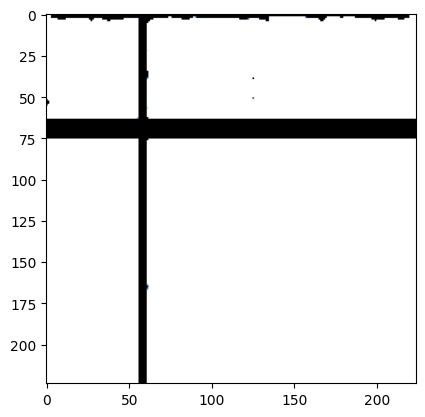

In [26]:
import matplotlib.pyplot as plt

plt.imshow(first_batch["pixel_values"][3].permute(1, 2, 0).numpy())

Applying training transform before viewing...
Generating spectrogram for sample index: 15
Fetching raw sample at index 15...
Raw sample fetched successfully.
Dataset format reset.
Processing audio...
Audio processed successfully.
Plotting spectrogram shape: (128, 126)


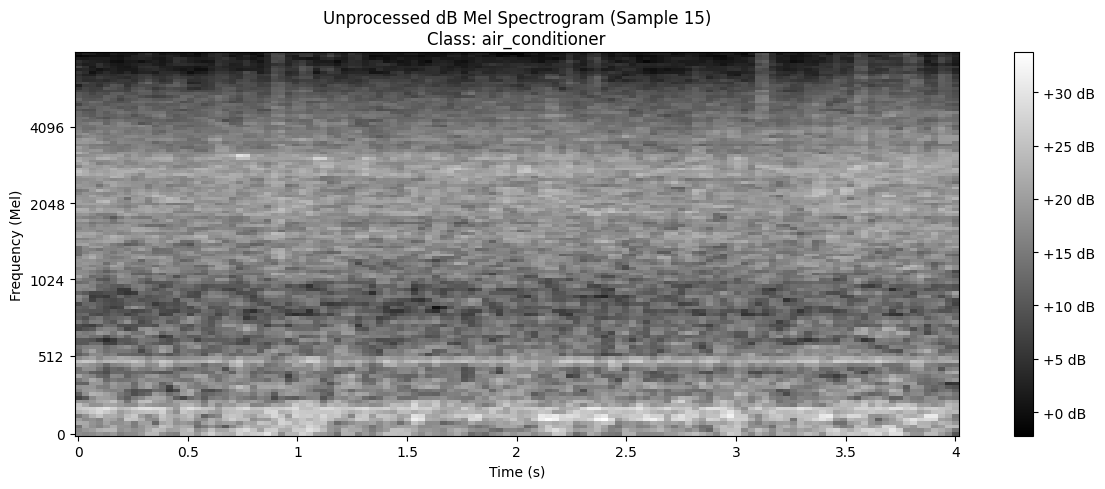

Plot displayed.
Generating spectrogram for sample index: 1702
Fetching raw sample at index 1702...
Raw sample fetched successfully.
Dataset format reset.
Processing audio...
Audio processed successfully.
Plotting spectrogram shape: (128, 38)


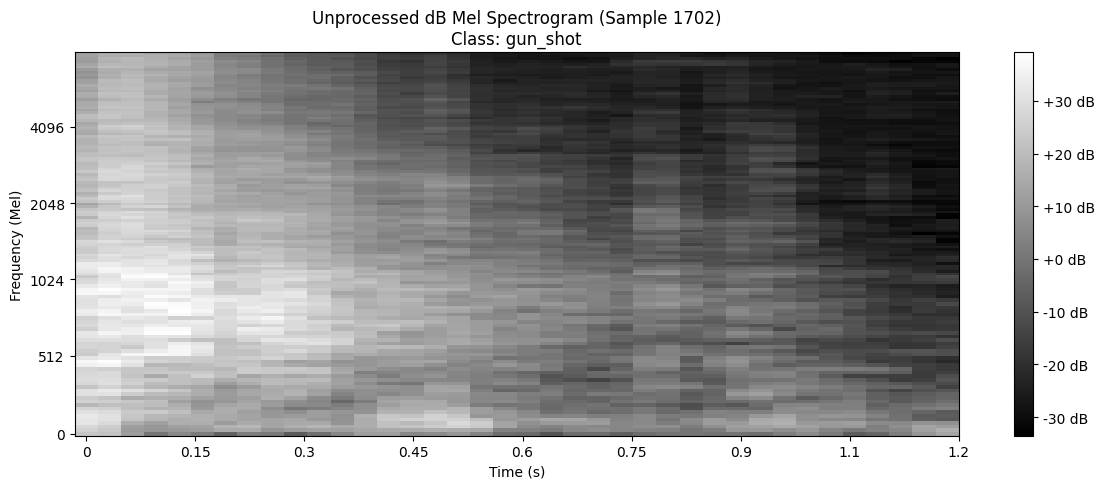

Plot displayed.


In [27]:
import torch
import torchaudio.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch.nn.functional as F
from datasets import Dataset as HFDataset  # Import for type hinting
import time

# --- Make sure Parameters are defined globally or pass them ---
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
TARGET_SAMPLE_RATE = 16000

# --- Define necessary Transforms (can be global) ---
mel_spectrogram_viz_transform = T.MelSpectrogram(
    sample_rate=TARGET_SAMPLE_RATE,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
    power=2.0,
)
amplitude_to_db_viz_transform = T.AmplitudeToDB(stype="power", top_db=80.0)


def display_unprocessed_spectrogram(dataset: HFDataset, index: int):
    """
    Loads a sample from the dataset (temporarily bypassing set_transform),
    calculates its dB Mel spectrogram, and displays it using librosa.

    Args:
        dataset: The Hugging Face Dataset object (e.g., train_dataset).
        index: The integer index of the sample to display.
    """
    if not isinstance(index, int) or index < 0 or index >= len(dataset):
        print(f"Error: Index {index} is out of bounds for dataset size {len(dataset)}")
        return

    print(f"Generating spectrogram for sample index: {index}")

    # --- Get the raw sample using set_format(None) ---
    try:
        # Temporarily set format to None to bypass python function transforms
        dataset.set_format(type=None)
        print(f"Fetching raw sample at index {index}...")
        raw_sample = dataset[index]  # Get the raw dictionary
        print("Raw sample fetched successfully.")
    except Exception as e:
        print(f"Error getting raw sample at index {index}: {e}")
        # Ensure format is reset even if fetching fails
        dataset.reset_format()
        print("Dataset format reset after error.")
        return
    finally:
        # --- IMPORTANT: Reset format back to default ---
        # This allows subsequent calls (e.g., by DataLoader) to use the transform
        # that was previously set by set_transform.
        dataset.reset_format()
        print("Dataset format reset.")

    # --- Basic Validation ---
    if (
        not isinstance(raw_sample, dict)
        or "audio" not in raw_sample
        or not isinstance(raw_sample["audio"], dict)
    ):
        print(f"Error: Sample at index {index} does not have the expected structure.")
        return

    # --- Extract and Preprocess Audio ---
    try:
        print("Processing audio...")
        audio_data = raw_sample["audio"]
        waveform = torch.from_numpy(audio_data["array"]).float()
        sample_rate = audio_data["sampling_rate"]
        class_name = raw_sample.get("class", "N/A")

        # 1. Resample if necessary
        if sample_rate != TARGET_SAMPLE_RATE:
            # Create resampler instance *only when needed*
            resampler = T.Resample(orig_freq=sample_rate, new_freq=TARGET_SAMPLE_RATE)
            waveform = resampler(waveform)
            sample_rate = TARGET_SAMPLE_RATE  # Use target rate from now on

        # 2. Convert to mono if necessary
        if waveform.ndim > 1 and waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0)
        if waveform.ndim == 0:
            waveform = waveform.unsqueeze(0)

        # 3. Pad if necessary
        required_len = N_FFT
        original_len = waveform.shape[-1]
        if original_len < required_len:
            padding_needed = required_len - original_len
            waveform = F.pad(waveform, (0, padding_needed))
            # print(f"Info: Padded waveform from {original_len} to {waveform.shape[-1]} samples.") # Optional debug

        # 4. Calculate dB Mel Spectrogram
        mel_spec_tensor = mel_spectrogram_viz_transform(waveform)
        db_mel_spec_tensor = amplitude_to_db_viz_transform(mel_spec_tensor)

        # 5. Convert for plotting
        db_mel_spectrogram_np = db_mel_spec_tensor.squeeze().cpu().numpy()
        print("Audio processed successfully.")

    except Exception as e:
        print(f"Error processing audio for sample {index}: {e}")
        import traceback

        traceback.print_exc()
        return

    # --- Plotting ---
    print(f"Plotting spectrogram shape: {db_mel_spectrogram_np.shape}")
    plt.figure(figsize=(12, 5))
    try:
        img = librosa.display.specshow(
            db_mel_spectrogram_np,
            sr=sample_rate,  # Should be TARGET_SAMPLE_RATE
            hop_length=HOP_LENGTH,
            x_axis="time",
            y_axis="mel",
            cmap="gray",
        )
        plt.colorbar(img, format="%+2.0f dB")
        plt.title(
            f"Unprocessed dB Mel Spectrogram (Sample {index})\nClass: {class_name}"
        )
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Mel)")
        plt.tight_layout()
        plt.show()
        print("Plot displayed.")
    except Exception as e:
        print(f"Error during plotting: {e}")


# --- Example Usage ---
# Make sure train_dataset is loaded and valid
if "train_dataset" in locals() and train_dataset is not None:
    # It's good practice to ensure the main transform is set before viewing
    # Or handle cases where it might not be set yet
    # if train_dataset.transform is None: # Check if transform attribute exists and is None (more robust needed if attr doesn't exist)
    try:
        print("Applying training transform before viewing...")
        train_transform_fn = preprocess_data(is_training=True)  # Ensure this is defined
        train_dataset.set_transform(train_transform_fn)
    except NameError:
        print("Warning: train_transform_fn not defined. Cannot set transform.")
    except Exception as e:
        print(f"Warning: Failed to set transform - {e}")

    display_unprocessed_spectrogram(train_dataset, 15)  # Display sample index 15
    display_unprocessed_spectrogram(train_dataset, 1702)  # Display another sample

    # Verify transform is still active after viewing (it should be due to reset_format)
    # print("\nVerifying transform is still active...")
    # try:
    #    sample_after = train_dataset[0]
    #    print("Keys after viewing:", sample_after.keys()) # Should be pixel_values, labels
    # except Exception as e:
    #    print(f"Error accessing sample after viewing: {e}")

else:
    print("train_dataset not found. Cannot display spectrogram.")


--- Visualizing Transform Stages for Sample Index: 15 ---
Mode: TRAINING (with Augmentation)


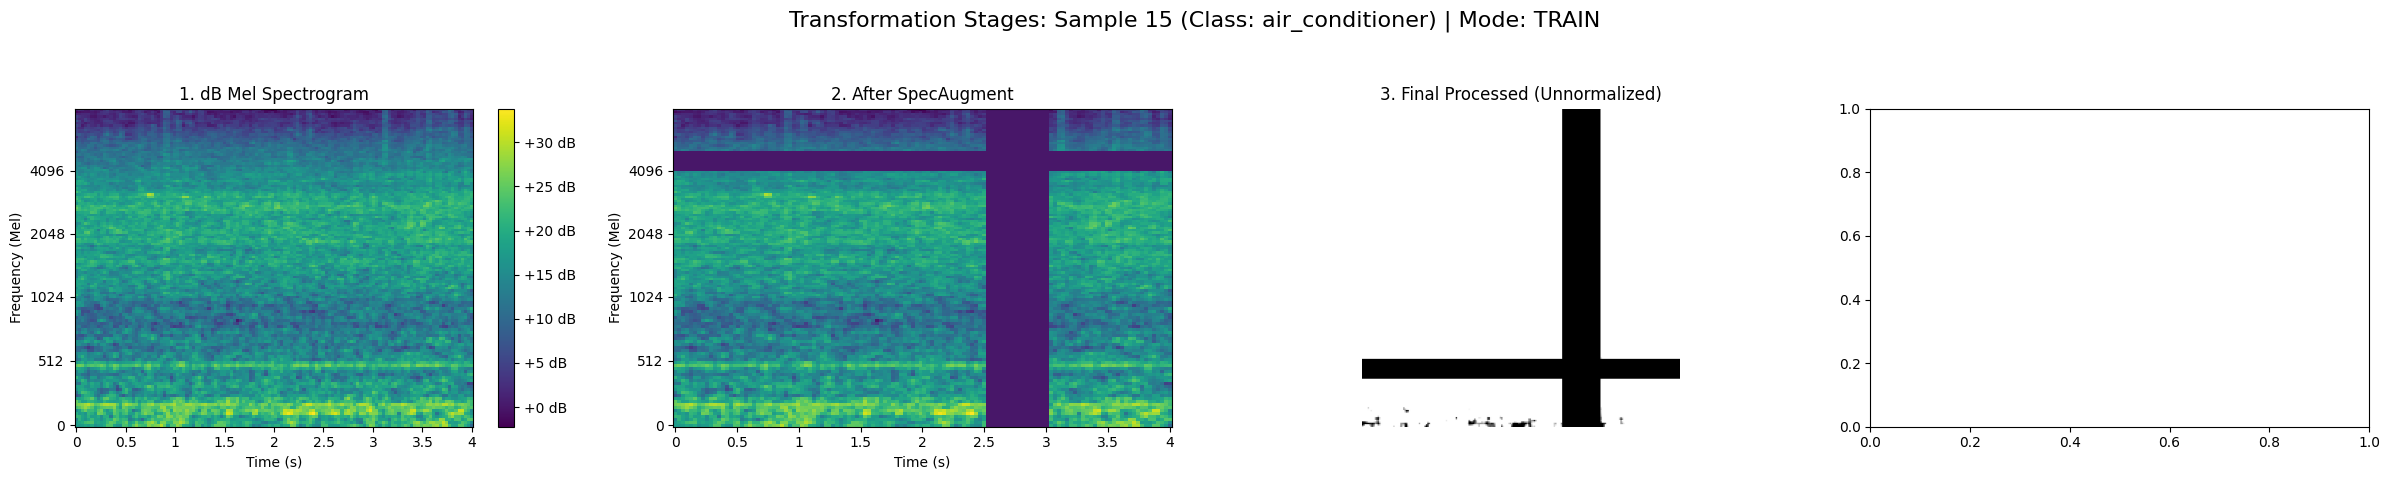


--- Visualizing Transform Stages for Sample Index: 15 ---
Mode: EVALUATION (no Augmentation)


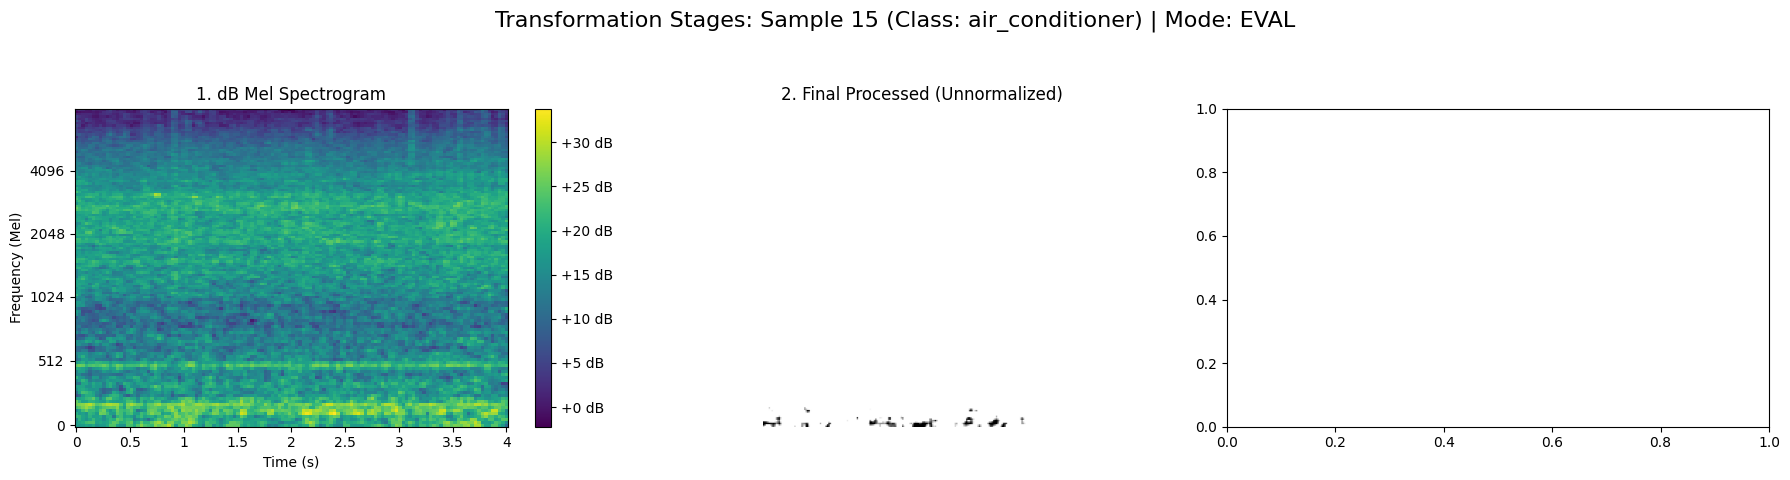

In [ ]:
import torch
import torch.nn as nn
import torchaudio.transforms as T
import torchvision.transforms as TV
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch.nn.functional as F
from datasets import Dataset as HFDataset  # Import for type hinting
import random
import traceback  # For printing full tracebacks on error

# --- Ensure Parameters are defined ---
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
TARGET_SAMPLE_RATE = 16000
VIT_INPUT_SIZE = (224, 224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
FREQ_MASK_PARAM = 15  # Use the values you set
TIME_MASK_PARAM = 20  # Use the values you set

# --- Ensure Reusable Transform Components are defined ---
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=TARGET_SAMPLE_RATE,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
    power=2.0,
)
amplitude_to_db_transform = T.AmplitudeToDB(stype="power", top_db=80.0)
freq_mask_transform = T.FrequencyMasking(freq_mask_param=FREQ_MASK_PARAM)
time_mask_transform = T.TimeMasking(time_mask_param=TIME_MASK_PARAM)


class HandleChannels(nn.Module):
    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        if spec.ndim == 2:
            spec = spec.unsqueeze(0)
        if spec.shape[0] == 1:
            spec = spec.repeat(3, 1, 1)
        return spec


handle_channels_transform = HandleChannels()
resize_transform = TV.Resize(VIT_INPUT_SIZE, antialias=True)
normalize_transform = TV.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)


# --- Unnormalize Function ---
def unnormalize(tensor, mean, std, inplace=False):
    if not inplace:
        tensor = tensor.clone()
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(
        -1, 1, 1
    )
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    tensor = torch.clamp(tensor, 0.0, 1.0)
    return tensor


# --- CORRECTED Visualization Function ---
def visualize_transform_stages(dataset: HFDataset, index: int, is_training: bool):
    """
    Visualizes key stages of the spectrogram transformation for a single sample.
    Uses set_format/reset_format to get raw data safely.
    """
    # --- Parameter / Transform Check ---
    # (Keep checks for required globals if you prefer)

    if not isinstance(index, int) or index < 0 or index >= len(dataset):
        print(f"Error: Index {index} is out of bounds for dataset size {len(dataset)}")
        return

    print(f"\n--- Visualizing Transform Stages for Sample Index: {index} ---")
    print(
        f"Mode: {'TRAINING (with Augmentation)' if is_training else 'EVALUATION (no Augmentation)'}"
    )

    # --- Get Raw Sample (Safely using set_format/reset_format) --- # CORRECTED BLOCK
    raw_sample = None
    try:
        # Temporarily set format to None to bypass python function transforms
        # This effectively makes dataset[index] return raw python dict
        dataset.set_format(type=None)
        raw_sample = dataset[index]
    except Exception as e:
        print(f"Error getting raw sample at index {index}: {e}")
        dataset.reset_format()  # Ensure format is reset even if fetching fails
        return
    finally:
        # --- IMPORTANT: Reset format back to default ---
        # This ensures the dataset behaves as expected (with set_transform) afterwards
        dataset.reset_format()
    # --- END CORRECTED BLOCK ---

    # --- Basic Validation ---
    if (
        not isinstance(raw_sample, dict)
        or "audio" not in raw_sample
        or not isinstance(raw_sample["audio"], dict)
    ):
        print(
            f"Error: Sample at index {index} does not have the expected structure ({type(raw_sample)})."
        )
        return

    # --- Store intermediate results ---
    stages = {}

    # --- Extract and Preprocess Waveform ---
    try:
        audio_data = raw_sample["audio"]
        waveform = torch.from_numpy(audio_data["array"]).float()
        sample_rate = audio_data["sampling_rate"]
        class_name = raw_sample.get("class", "N/A")

        # Resample
        if sample_rate != TARGET_SAMPLE_RATE:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=TARGET_SAMPLE_RATE)
            waveform = resampler(waveform)
            sample_rate = TARGET_SAMPLE_RATE  # Now fixed
        # Mono
        if waveform.ndim > 1 and waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0)
        if waveform.ndim == 0:
            waveform = waveform.unsqueeze(0)
        # Pad
        required_len = N_FFT
        if waveform.shape[-1] < required_len:
            padding_needed = required_len - waveform.shape[-1]
            waveform = F.pad(waveform, (0, padding_needed))
        processed_waveform = waveform.clone()  # Use this for both paths

    except Exception as e:
        print(f"Error preprocessing waveform: {e}")
        traceback.print_exc()
        return

    # --- Apply Transforms Step-by-Step for Visualization ---
    try:
        # 1. dB Mel Spectrogram
        mel_spec = mel_spectrogram_transform(processed_waveform)
        db_mel_spec = amplitude_to_db_transform(mel_spec)
        stages["dB Mel Spectrogram"] = db_mel_spec.squeeze().cpu().numpy()

        # 2. After SpecAugment (if training)
        current_spec_for_processing = db_mel_spec  # Input for next steps
        if is_training:
            augmented_spec = current_spec_for_processing.clone()  # Augment a copy
            augmented_spec = freq_mask_transform(augmented_spec)
            augmented_spec = time_mask_transform(augmented_spec)
            stages["After SpecAugment"] = augmented_spec.squeeze().cpu().numpy()
            current_spec_for_processing = (
                augmented_spec  # Use augmented spec for final steps
            )
        else:
            stages["After SpecAugment"] = None  # Placeholder if not training

        # 3. Final Processed Tensor (apply remaining steps)
        remaining_transforms = TV.Compose(
            [handle_channels_transform, resize_transform, normalize_transform]
        )
        final_normalized_tensor = remaining_transforms(current_spec_for_processing)

        # 4. Unnormalize final tensor for plotting
        final_unnormalized = unnormalize(
            final_normalized_tensor, IMAGENET_MEAN, IMAGENET_STD
        )
        stages["Final Processed (Unnormalized)"] = (
            final_unnormalized.permute(1, 2, 0).cpu().numpy()
        )

    except Exception as e:
        print(f"Error applying transforms step-by-step: {e}")
        traceback.print_exc()
        return

    # --- Plotting ---
    num_plots = 4 if is_training and stages["After SpecAugment"] is not None else 3
    fig, axs = plt.subplots(1, num_plots, figsize=(num_plots * 6, 5))
    # Ensure axs is always iterable, even if num_plots is 1 (though unlikely here)
    if num_plots == 1:
        axs = [axs]
    fig.suptitle(
        f'Transformation Stages: Sample {index} (Class: {class_name}) | Mode: {"TRAIN" if is_training else "EVAL"}',
        fontsize=16,
    )

    plot_idx = 0

    # Plot 1: dB Mel Spectrogram
    try:
        ax = axs[plot_idx]
        img = librosa.display.specshow(
            stages["dB Mel Spectrogram"],
            sr=TARGET_SAMPLE_RATE,
            hop_length=HOP_LENGTH,
            x_axis="time",
            y_axis="mel",
            cmap="viridis",
            ax=ax,
        )
        fig.colorbar(img, ax=ax, format="%+2.0f dB")
        ax.set_title("1. dB Mel Spectrogram")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Mel)")
        plot_idx += 1
    except Exception as e:
        print(f"Error plotting dB Mel Spec: {e}")
        if plot_idx < len(axs):
            axs[plot_idx].set_title("Error plotting dB Mel Spec")
            plot_idx += 1

    # Plot 2: After SpecAugment (only if training and available)
    if is_training and stages["After SpecAugment"] is not None:
        try:
            ax = axs[plot_idx]
            img = librosa.display.specshow(
                stages["After SpecAugment"],
                sr=TARGET_SAMPLE_RATE,
                hop_length=HOP_LENGTH,
                x_axis="time",
                y_axis="mel",
                cmap="viridis",
                ax=ax,
            )
            ax.set_title("2. After SpecAugment")
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Frequency (Mel)")
            plot_idx += 1
        except Exception as e:
            print(f"Error plotting Augmented Spec: {e}")
            if plot_idx < len(axs):
                axs[plot_idx].set_title("Error plotting Aug Spec")
                plot_idx += 1

    # Plot 3: Final Processed (Unnormalized)
    try:
        ax = axs[plot_idx]
        ax.imshow(stages["Final Processed (Unnormalized)"])
        final_title_num = plot_idx + 1
        ax.set_title(f"{final_title_num}. Final Processed (Unnormalized)")
        ax.axis("off")
    except Exception as e:
        print(f"Error plotting Final Unnormalized: {e}")
        if plot_idx < len(axs):
            axs[plot_idx].set_title("Error plotting Final")

    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()


# --- Example Usage (remains the same) ---
if "train_dataset" in locals() and train_dataset is not None:
    visualize_transform_stages(train_dataset, 15, is_training=True)
    visualize_transform_stages(train_dataset, 15, is_training=False)
else:
    print("train_dataset not found. Cannot run visualization.")